## Differential privacy is a novel concept of objectively defining the level of privacy that can be provided when sharing sensitive data. The core idea is to intelligently add noise to data such that when aggregated the data still shows accurate trends despite the added noise. The trade-off between accuracy and privacy is objectively defined and can be controlled through a parameter called Epsilon. This notebook is an attempt to introduce a quick and easy way to demonstrate this concept.

In [1]:
#Installing pydp package
pip install python-dp

Note: you may need to restart the kernel to use updated packages.


### The PyDP package implements differentially private functions for aggregating data

In [2]:
#Importing necessary packages
import pydp as dp
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, Count, Max
import pandas as pd
import statistics

### We will read a sample dataset with sensitive sales information along with personal details like name and email. I will add my details to this dataset and demonstrate how its possible to identify my personal information from this data even if name and email were anonymized.

In [24]:
#Reading sample sales data
url1 = "https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial_4-Launch_demo/data/01.csv"
original_df = pd.read_csv(url1, sep=",", engine="python")
original_df.head(), original_df.shape

(   id first_name   last_name                      email  sales_amount  \
 0   1   Osbourne    Gillions  ogillions0@feedburner.com         31.94   
 1   2      Glynn      Friett          gfriett1@blog.com         12.46   
 2   3       Jori    Blockley      jblockley2@unesco.org        191.14   
 3   4     Garald      Dorian     gdorian3@webeden.co.uk        126.58   
 4   5      Mercy  Pilkington      mpilkington4@jugem.jp         68.32   
 
         state  
 0     Florida  
 1  California  
 2    Colorado  
 3       Texas  
 4     Florida  ,
 (1000, 6))

In [25]:
#Adding my sales info with sales amount as 250
added_df = pd.concat([original_df,pd.DataFrame({'id':1001,'first_name':'Jayadev','last_name':'KP','email':'jayadev@dummy.com','sales_amount':250.0,'state':'Minnesota'},index=[1000])])

In [26]:
#The last row has the newly added data
added_df

,id,first_name,last_name,email,sales_amount,state
0,1,Osbourne,Gillions,ogillions0@feedburner.com,31.94,Florida
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida
...,...,...,...,...,...,...
996,997,Zacharie,Powdrill,zpowdrillro@domainmarket.com,136.94,Colorado
997,998,Burty,Aucutt,baucuttrp@blogtalkradio.com,218.39,Texas
998,999,Aili,Hale,ahalerq@ask.com,164.54,Pennsylvania
999,1000,Giffard,Eagland,geaglandrr@github.com,173.33,Wyoming


### Suppose we had access to query this data such that we get accurate aggregate sales for certain users without having de-anonymized data. Even in such a system we can extract an individuals sales by computing the difference in total sales for the whole dataset from total sales for a dataset with my information excluded.

In [29]:
sum_added = sum(added_df["sales_amount"].to_list())
sum_original = sum(original_df["sales_amount"].to_list())
sales_amount_Jayadev = (sum_added - sum_original)
#My sales info
sales_amount_Jayadev

250.0

### In a differentially private system, we can add "intelligent" noise to this sum such that there is a slight inaccuracy which does not destroy the analytical capability in the data but makes it impossible to determine a certain individuals sales info

In [30]:
#Defining a bounded differentially private function to sum the sales in data which excludes my info. 
#Note: We assume individual sales cant be less than $5 or greater than $300.
dp_sum_original = BoundedSum(
    epsilon=1, lower_bound=5, upper_bound=300, dtype="float"
)

In [31]:
dp_sum_original.reset()
dp_sum_original.add_entries(
    original_df["sales_amount"].to_list()
)

In [32]:
#Aggregate sales with DP
dp_sum_og = dp_sum_original.result()
dp_sum_og

128107.32515908545

In [33]:
#Defining a bounded differentially private function to sum the sales in data which includes my info. 
dp_sum_added = BoundedSum(epsilon=1, lower_bound=5, upper_bound=300, dtype="float")
dp_sum_added.add_entries(added_df["sales_amount"].to_list())

In [34]:
#Aggregate sales with DP
dp_sum_add = dp_sum_added.result()
dp_sum_add

128877.47793508228

### Note below that subtracting the differentially private sums does not reveal my sales information

In [35]:
dp_sum_add - dp_sum_og

770.1527759968303

In [36]:
print("Difference in sum using DP: {}".format(round(dp_sum_add - dp_sum_og, 2)))
print("Actual Value: {}".format(sales_amount_Jayadev))

Difference in sum using DP: 770.15
Actual Value: 250.0


### As we show below, despite adding noise we still have less than 1% change in the differentially private aggregate sales vs the unaltered aggregate sales

In [37]:
print("Sum of sales_value in the original Dataset: {}".format(sum_original))
print("Sum of sales_value in the original Dataset using DP: {}".format(dp_sum_og))

Sum of sales_value in the original Dataset: 127931.37999999984
Sum of sales_value in the original Dataset using DP: 128107.32515908545


In [38]:
print("Sum of sales_value in the added Dataset: {}".format(sum_added))
print("Sum of sales_value in the added Dataset using DP: {}".format(dp_sum_add))

Sum of sales_value in the added Dataset: 128181.37999999984
Sum of sales_value in the added Dataset using DP: 128877.47793508228


### Another important aspect of DP is the ability to control the amount of noise added through a parameter called Epsilon. As we lower this value the inaccuracy in data increases thereby providing more privacy but this comes at the cost of analytical utility. In the below section we show this tradeoff by calculating the difference in sum of sales for various values of epsilon. We do this for 100 different iterations to account for the randomness of the noise being added

In [45]:
#Calculating the difference in sum of sales for different epsilon values across 100 iterations
sum_diff_dp_all = []
for simulation in range(100):
    sum_diff_dp = []
    for eps in [0.1,1,10,100]:
        dp_sum_original = BoundedSum(epsilon=eps, lower_bound=5, upper_bound=300, dtype="float")
        dp_sum_original.reset()
        dp_sum_original.add_entries(original_df["sales_amount"].to_list())
        dp_sum_added = BoundedSum(epsilon=eps, lower_bound=5, upper_bound=300, dtype="float")
        dp_sum_added.add_entries(added_df["sales_amount"].to_list())
        sum_diff_dp.append(round(dp_sum_added.result() - dp_sum_original.result(), 2))
    sum_diff_dp_all.append(sum_diff_dp)

In [47]:
df = pd.DataFrame(sum_diff_dp_all,columns = ['eps_0.1' , 'eps_1', 'eps_10' , 'eps_100'])

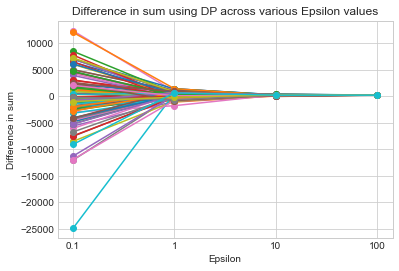

In [60]:
#Plotting the above calculated values across Epsilon values
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

plt.title('Difference in sum using DP across various Epsilon values')
plt.xlabel('Epsilon')
plt.ylabel('Difference in sum')
x = range(4)
for i in range(len(sum_diff_dp_all)):
    plt.plot(x, sum_diff_dp_all[i], marker='o')
plt.xticks(x,[0.1 , 1, 10 , 100])
plt.show()



### As seen above, lower the Epsilon value, greater the amount of noise added. As epsilon value increases, the estimate becomes closer to the actual value ($ 250)

## The above code was inspired by Open Mined's Python Wrapper for Google's Differential Privacy project. The link for their page is here:https://blog.openmined.org/.

## Also check out my presentation on the basics on Differential Privacy here: https://www.youtube.com/watch?v=C3KnAsXqJHQ